## Importing data (Alex updated: 4/30/19)

In [1]:
import numpy as np

# Image processing tools
import skimage
import skimage.filters

import pandas as pd
import scipy.optimize
import scipy.stats as st
import numba
import itertools

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from numpy.linalg import inv

from tqdm import tqdm, trange
from scipy import special, optimize
from scipy import integrate

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
#plotly.tools.set_credentials_file(username='AYChoi', api_key='ZacDa7fKo8hfiELPfs57')
plotly.tools.set_credentials_file(username='AlexanderYChoi', api_key='VyLt05wzc89iXwSC82FO')

Load the e-ph matrix elements data. The two numbers reported at the end should be the same. If they are not, there are duplicate e-ph elements. It's VERY IMPORTANT to note that the g elements here are actually |g|^2 which is why they are real numbers.

In [2]:
data = pd.read_csv('gaas.eph_matrix', sep='\t',header= None,skiprows=(0,1))
data.columns = ['0']
data_array = data['0'].values
new_array = np.zeros((len(data_array),7))
for i1 in trange(len(data_array)):
    new_array[i1,:] = data_array[i1].split()
    
g_df = pd.DataFrame(data=new_array,columns = ['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode','g_element'])
g_df[['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode']] = g_df[['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode']].apply(pd.to_numeric,downcast = 'integer')
len(g_df[['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode','g_element']]),len(g_df[['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode','g_element']].drop_duplicates())

100%|█████████████████████████████████████████████████████████████████████| 7854608/7854608 [03:03<00:00, 42864.89it/s]


(7854608, 7854608)

Now load the k-point indices, q-point indices, k-point energies, phonon energies into dataframes.

In [3]:
kpts = pd.read_csv('gaas.kpts', sep='\t',header= None)
kpts.columns = ['0']
kpts_array = kpts['0'].values
new_kpt_array = np.zeros((len(kpts_array),4))
for i1 in trange(len(kpts_array)):
    new_kpt_array[i1,:] = kpts_array[i1].split()
    
kpts_df = pd.DataFrame(data=new_kpt_array,columns = ['k_inds','b1','b2','b3'])
kpts_df[['k_inds']] = kpts_df[['k_inds']].apply(pd.to_numeric,downcast = 'integer')
kpts_df.head()

100%|██████████████████████████████████████████████████████████████████████████| 2213/2213 [00:00<00:00, 316964.72it/s]


,k_inds,b1,b2,b3
0,1,0.0,0.0,0.00
1,2,0.0,0.0,0.01
2,3,0.0,0.0,0.02
3,4,0.0,0.0,0.03
4,5,0.0,0.0,0.04


In [4]:
enk = pd.read_csv('gaas.enk', sep='\t',header= None)
enk.columns = ['0']
enk_array = enk['0'].values
new_enk_array = np.zeros((len(enk_array),3))
for i1 in trange(len(enk_array)):
    new_enk_array[i1,:] = enk_array[i1].split()
    
enk_df = pd.DataFrame(data=new_enk_array,columns = ['k_inds','band_inds','energy [Ryd]'])
enk_df[['k_inds','band_inds']] = enk_df[['k_inds','band_inds']].apply(pd.to_numeric,downcast = 'integer')
enk_df.head()

100%|██████████████████████████████████████████████████████████████████████████| 2213/2213 [00:00<00:00, 277339.39it/s]


,k_inds,band_inds,energy [Ryd]
0,1,1,0.445788
1,2,1,0.447866
2,3,1,0.453308
3,4,1,0.460652
4,5,1,0.468793


In [5]:
enq = pd.read_csv('gaas.enq', sep='\t',header= None)
enq.columns = ['0']
enq_array = enq['0'].values
new_enq_array = np.zeros((len(enq_array),3))
for i1 in trange(len(enq_array)):
    new_enq_array[i1,:] = enq_array[i1].split()
    
enq_df = pd.DataFrame(data=new_enq_array,columns = ['q_inds','im_mode','energy [Ryd]'])
enq_df[['q_inds','im_mode']] = enq_df[['q_inds','im_mode']].apply(pd.to_numeric,downcast = 'integer')
enq_df.head()

100%|██████████████████████████████████████████████████████████████████████| 126480/126480 [00:00<00:00, 338182.40it/s]


,q_inds,im_mode,energy [Ryd]
0,1,1,0.000020
1,1,2,0.000026
2,1,3,0.000054
3,1,4,0.002432
4,1,5,0.002432


In [6]:
qpts = pd.read_csv('gaas.qpts', sep='\t',header= None)
qpts.columns = ['0']
qpts_array = qpts['0'].values
new_qpt_array = np.zeros((len(qpts_array),4))

for i1 in trange(len(qpts_array)):
    new_qpt_array[i1,:] = qpts_array[i1].split()
    
qpts_df = pd.DataFrame(data=new_qpt_array,columns = ['q_inds','b1','b2','b3'])
qpts_df[['q_inds']] = qpts_df[['q_inds']].apply(pd.to_numeric,downcast = 'integer')
qpts_df.head()

100%|████████████████████████████████████████████████████████████████████████| 21080/21080 [00:00<00:00, 306326.47it/s]


,q_inds,b1,b2,b3
0,1,0.0,0.0,0.01
1,2,0.0,0.0,0.02
2,3,0.0,0.0,0.03
3,4,0.0,0.0,0.04
4,5,0.0,0.0,0.05


## Data Processing (Alex Updated: 4/30)

In [7]:
def cartesian_q_points(qpts_df):
    """
    Given a dataframe containing indexed q-points in terms of the crystal lattice vector, return the dataframe with cartesian q coordinates.     
    Parameters:
    -----------
    qpts_df : pandas dataframe containing:
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        kx : vector_like, shape (n,1)
        x-coordinate in momentum space [1/A]    
        
        ky : vector_like, shape (n,1)
        y-coordinate in momentum space [1/A]  
        
        kz : vector_like, shape (n,1)
        z-coordinate in momentum space [1/A]
        
    For FCC lattice, use the momentum space primitive vectors as per:
    http://lampx.tugraz.at/~hadley/ss1/bzones/fcc.php
    
    b1 = 2 pi/a (kx - ky + kz)
    b2 = 2 pi/a (kx + ky - kz)
    b3 = 2 pi/a (-kx + ky + kz)
    
    Returns:
    --------
    cart_kpts_df : pandas dataframe containing:
    
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        kx : vector_like, shape (n,1)
        x-coordinate in Cartesian momentum space [1/m]    
        
        ky : vector_like, shape (n,1)
        y-coordinate in Cartesian momentum space [1/m]  
        
        kz : vector_like, shape (n,1)
        z-coordinate in Cartesian momentum space [1/m]  
    """
    
    # Need a lattice constant for GaAs. This is obviously somewhat sensitive to temperature.
    a = 5.556 #[A]
    
    cartesian_df = pd.DataFrame(columns = ['q_inds','kx [1/A]','ky [1/A]','kz [1/A]'])
    
    con1 = pd.DataFrame(columns = ['kx [1/A]','ky [1/A]','kz [1/A]'])
    con1['kx [1/A]'] = np.ones(len(qpts_df))*-1
    con1['ky [1/A]'] = np.ones(len(qpts_df))*-1
    con1['kz [1/A]'] = np.ones(len(qpts_df))*1

    con2 = con1.copy(deep=True)
    con2['kx [1/A]'] = con2['kx [1/A]'].values*-1
    con2['ky [1/A]'] = con2['ky [1/A]'].values*-1

    con3 = con1.copy(deep=True)
    con3['ky [1/A]'] = con2['ky [1/A]'].values
    con3['kz [1/A]'] = con3['kz [1/A]'].values*-1
    
    
    cartesian_df['kx [1/A]'] = np.multiply(qpts_df['b1'].values,(con1['kx [1/A]'].values)) + np.multiply(qpts_df['b2'].values,(con2['kx [1/A]'].values)) + np.multiply(qpts_df['b3'].values,(con3['kx [1/A]'].values))
    cartesian_df['ky [1/A]'] = np.multiply(qpts_df['b1'].values,(con1['ky [1/A]'].values)) + np.multiply(qpts_df['b2'].values,(con2['ky [1/A]'].values)) + np.multiply(qpts_df['b3'].values,(con3['ky [1/A]'].values))
    cartesian_df['kz [1/A]'] = np.multiply(qpts_df['b1'].values,(con1['kz [1/A]'].values)) + np.multiply(qpts_df['b2'].values,(con2['kz [1/A]'].values)) + np.multiply(qpts_df['b3'].values,(con3['kz [1/A]'].values))

    cartesian_df['q_inds'] = qpts_df['q_inds'].values
    
    cartesian_df_edit = cartesian_df.copy(deep=True)

    qx_plus = cartesian_df['kx [1/A]'] > 0.5
    qx_minus = cartesian_df['kx [1/A]'] < -0.5

    qy_plus = cartesian_df['ky [1/A]'] > 0.5
    qy_minus = cartesian_df['ky [1/A]'] < -0.5

    qz_plus = cartesian_df['kz [1/A]'] > 0.5
    qz_minus = cartesian_df['kz [1/A]'] < -0.5

    cartesian_df_edit.loc[qx_plus,'kx [1/A]'] = cartesian_df.loc[qx_plus,'kx [1/A]'] -1
    cartesian_df_edit.loc[qx_minus,'kx [1/A]'] = cartesian_df.loc[qx_minus,'kx [1/A]'] +1

    cartesian_df_edit.loc[qy_plus,'ky [1/A]'] = cartesian_df.loc[qy_plus,'ky [1/A]'] -1
    cartesian_df_edit.loc[qy_minus,'ky [1/A]'] = cartesian_df.loc[qy_minus,'ky [1/A]'] +1

    cartesian_df_edit.loc[qz_plus,'kz [1/A]'] = cartesian_df.loc[qz_plus,'kz [1/A]'] -1
    cartesian_df_edit.loc[qz_minus,'kz [1/A]'] = cartesian_df.loc[qz_minus,'kz [1/A]'] +1
    
    return cartesian_df,cartesian_df_edit

In [8]:
a = 5.556 #[A]
kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
T = 300
e = 1.602*10**(-19)

In [9]:
kvel = pd.read_csv('gaas.vel', sep='\t',header= None,skiprows=[0,1,2])
kvel.columns = ['0']
kvel_array = kvel['0'].values
new_kvel_array = np.zeros((len(kvel_array),10))
for i1 in trange(len(kvel_array)):
    new_kvel_array[i1,:] = kvel_array[i1].split()
    
kvel_df = pd.DataFrame(data=new_kvel_array,columns = ['k_inds','bands','energy','kx [2pi/alat]','ky [2pi/alat]','kz [2pi/alat]','vx_dir','vy_dir','vz_dir','v_mag [m/s]'])
kvel_df[['k_inds']] = kvel_df[['k_inds']].apply(pd.to_numeric,downcast = 'integer')

kvel_edit = kvel_df.copy(deep=True)

kx_plus = kvel_df['kx [2pi/alat]'] > 0.5
kx_minus = kvel_df['kx [2pi/alat]'] < -0.5

ky_plus = kvel_df['ky [2pi/alat]'] > 0.5
ky_minus = kvel_df['ky [2pi/alat]'] < -0.5

kz_plus = kvel_df['kz [2pi/alat]'] > 0.5
kz_minus = kvel_df['kz [2pi/alat]'] < -0.5

kvel_edit.loc[kx_plus,'kx [2pi/alat]'] = kvel_df.loc[kx_plus,'kx [2pi/alat]'] -1
kvel_edit.loc[kx_minus,'kx [2pi/alat]'] = kvel_df.loc[kx_minus,'kx [2pi/alat]'] +1

kvel_edit.loc[ky_plus,'ky [2pi/alat]'] = kvel_df.loc[ky_plus,'ky [2pi/alat]'] -1
kvel_edit.loc[ky_minus,'ky [2pi/alat]'] = kvel_df.loc[ky_minus,'ky [2pi/alat]'] +1

kvel_edit.loc[kz_plus,'kz [2pi/alat]'] = kvel_df.loc[kz_plus,'kz [2pi/alat]'] -1
kvel_edit.loc[kz_minus,'kz [2pi/alat]'] = kvel_df.loc[kz_minus,'kz [2pi/alat]'] +1

kvel_df = kvel_edit.copy(deep=True)
kvel_df.head()

cart_kpts_df = kvel_df.copy(deep=True)
cart_kpts_df['kx [2pi/alat]'] = cart_kpts_df['kx [2pi/alat]'].values*2*np.pi/a
cart_kpts_df['ky [2pi/alat]'] = cart_kpts_df['ky [2pi/alat]'].values*2*np.pi/a
cart_kpts_df['kz [2pi/alat]'] = cart_kpts_df['kz [2pi/alat]'].values*2*np.pi/a

cart_kpts_df.columns = ['k_inds', 'bands', 'energy', 'kx [1/A]', 'ky [1/A]','kz [1/A]', 'vx_dir', 'vy_dir', 'vz_dir', 'v_mag [m/s]']


100%|██████████████████████████████████████████████████████████████████████████| 2213/2213 [00:00<00:00, 201949.32it/s]


In [10]:
cart_qpts_df,edit_cart_qpts_df = cartesian_q_points(qpts_df)

In [11]:
trace1 = go.Scatter3d(
    x=cart_kpts_df['kx [1/A]'].values/(2*np.pi/(a)),
    y=cart_kpts_df['ky [1/A]'].values/(2*np.pi/(a)),
    z=cart_kpts_df['kz [1/A]'].values/(2*np.pi/(a)),
    mode='markers',
    marker=dict(
        size=2,
        color=enk_df['energy [Ryd]'],
        colorscale='Rainbow',
        showscale=True,
        opacity=1
    )
)

trace2 = go.Scatter

data = [trace1]
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='kx',titlefont = dict(family='Oswald, monospace',size=18)),
                    yaxis = dict(
                        title='ky',titlefont = dict(family='Oswald, monospace',size=18)),
                    zaxis = dict(
                        title='kz',titlefont = dict(family='Oswald, monospace',size=18)),))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~AlexanderYChoi/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


C:\Users\AlexanderChoi\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [12]:
trace1 = go.Scatter3d(
    x=cart_kpts_df['kx [1/A]'].values/(2*np.pi/(a)),
    y=cart_kpts_df['ky [1/A]'].values/(2*np.pi/(a)),
    z=cart_kpts_df['kz [1/A]'].values/(2*np.pi/(a)),
    mode='markers',
    marker=dict(
        size=2,
        color=cart_kpts_df['v_mag [m/s]'],
        colorscale='Rainbow',
        showscale=True,
        opacity=1
    )
)

trace2 = go.Scatter

data = [trace1]
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='kx',titlefont = dict(family='Oswald, monospace',size=18)),
                    yaxis = dict(
                        title='ky',titlefont = dict(family='Oswald, monospace',size=18)),
                    zaxis = dict(
                        title='kz',titlefont = dict(family='Oswald, monospace',size=18)),))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~AlexanderYChoi/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


In [13]:
trace1 = go.Scatter3d(
    x=cart_kpts_df['kx [1/A]'].values/(2*np.pi/(a)),
    y=cart_kpts_df['ky [1/A]'].values/(2*np.pi/(a)),
    z=cart_kpts_df['kz [1/A]'].values/(2*np.pi/(a)),
    mode='markers',
    marker=dict(
        size=2,
        color=cart_kpts_df['k_inds'],
        colorscale='Rainbow',
        showscale=True,
        opacity=1
    )
)

trace2 = go.Scatter

data = [trace1]
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='kx',titlefont = dict(family='Oswald, monospace',size=18)),
                    yaxis = dict(
                        title='ky',titlefont = dict(family='Oswald, monospace',size=18)),
                    zaxis = dict(
                        title='kz',titlefont = dict(family='Oswald, monospace',size=18)),))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~AlexanderYChoi/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


In [14]:
trace1 = go.Scatter3d(
    x=edit_cart_qpts_df['kx [1/A]'].values,
    y=edit_cart_qpts_df['ky [1/A]'].values,
    z=edit_cart_qpts_df['kz [1/A]'].values,
    mode='markers',
    marker=dict(
        size=2,
        opacity=1
    )
)

data = [trace1]
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='kx',titlefont = dict(family='Oswald, monospace',size=18)),
                    yaxis = dict(
                        title='ky',titlefont = dict(family='Oswald, monospace',size=18)),
                    zaxis = dict(
                        title='kz',titlefont = dict(family='Oswald, monospace',size=18)),))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~AlexanderYChoi/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


In [16]:
def fermi_distribution(g_df,mu,T):
    """
    This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
    Parameters:
    -----------
    
    g_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
        
        
    mu : scalar
    Chemical potential of electronic states [eV]
    
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
         
    """
    # Physical constants    
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]


    g_df['k_FD'] = (np.exp((g_df['k_en [eV]'].values*e - mu*e)/(kb*T)) + 1)**(-1)
    g_df['k+q_FD'] = (np.exp((g_df['k+q_en [eV]'].values*e - mu*e)/(kb*T)) + 1)**(-1)

    return g_df

In [17]:
def bose_distribution(g_df,T):
    """
    This function takes a list of q-point indices and returns the Bose-Einstein distributions associated with each q-point on that list.    
    Parameters:
    -----------
    
    g_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
        
        
    mu : scalar
    Chemical potential of electronic states [eV]
    
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        BE : vector_like, shape (n,1)
        Bose-einstein distribution
         
    """
    # Physical constants    
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]

    g_df['BE'] = (np.exp((g_df['q_en [eV]'].values*e)/(kb*T)) - 1)**(-1)
    return g_df

In [18]:
def fermionic_processing(g_df,cart_kpts_df,enk_df,mu,T):
    """
    This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
    Parameters:
    -----------
    
    g_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
               
    cart_kpts_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point
        
        kx : vector_like, shape (n,1)
        x-coordinate in Cartesian momentum space [1/m]    
        
        ky : vector_like, shape (n,1)
        y-coordinate in Cartesian momentum space [1/m]  
        
        kz : vector_like, shape (n,1)
        z-coordinate in Cartesian momentum space [1/m]
        
    enk_df : pandas dataframe containing

        k_inds : vector_like, shape (n,1)
        Index of k point
        
        band_inds : vector_like, shape (n,1)
        Band index
        
        energy [Ryd] : vector_like, shape (n,1)
        Energy associated with k point in Rydberg units
        
        
    mu : scalar
    Chemical potential of electronic states [eV]
    
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
         
    """
    
    # Physical constants
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
    
    index_vector = cart_kpts_df['k_inds'].values    
    g_df['k_en [eV]'] = np.zeros(len(g_df))
    g_df['k+q_en [eV]'] = np.zeros(len(g_df))
    g_df['collision_state'] = np.zeros(len(g_df))
    
    for i1 in trange(len(cart_kpts_df)):
        index = index_vector[i1]
        
        g_slice_k = g_df['k_inds'] == index        
        g_slice_kq = g_df['k+q_inds'] == index
        
        k_slice = cart_kpts_df['k_inds'] == index
        enk_slice = enk_df['k_inds'] == index
        
        g_df.loc[g_slice_k,'k_en [eV]'] = enk_df.loc[enk_slice,'energy [Ryd]'].values*13.6056980659 
        g_df.loc[g_slice_kq,'k+q_en [eV]'] = enk_df.loc[enk_slice,'energy [Ryd]'].values*13.6056980659
        
    abs_inds = g_df['k_en [eV]'] < g_df['k+q_en [eV]'] #absorbed indices
    ems_inds = g_df['k_en [eV]'] > g_df['k+q_en [eV]'] #emission indices
    
    g_df.loc[abs_inds,'collision_state'] = 1
    g_df.loc[ems_inds,'collision_state'] = -1
    
    g_df = fermi_distribution(g_df,mu, T)
    
    return g_df

In [20]:
def bosonic_processing(g_df,enq_df,T):
    """
    This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
    Parameters:
    -----------
    
    g_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
               
    cart_qpts_df : pandas dataframe containing:
    
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        kx : vector_like, shape (n,1)
        x-coordinate in Cartesian momentum space [1/m]    
        
        ky : vector_like, shape (n,1)
        y-coordinate in Cartesian momentum space [1/m]  
        
        kz : vector_like, shape (n,1)
        z-coordinate in Cartesian momentum space [1/m]
        
    enq_df : pandas dataframe containing

        k_inds : vector_like, shape (n,1)
        Index of k point
        
        im_mode : vector_like, shape (n,1)
        Phonon polarization index
        
        energy [Ryd] : vector_like, shape (n,1)
        Energy associated with k point in Rydberg units
        
            
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
         
    """
    
    # Physical constants
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
    
    modified_g_df = g_df.copy(deep=True)
    modified_g_df.set_index(['q_inds', 'im_mode'], inplace=True)
    modified_g_df = modified_g_df.sort_index()
    modified_enq_df = enq_df.copy(deep=True)
    modified_enq_df.set_index(['q_inds', 'im_mode'], inplace=True)
    modified_enq_df = modified_enq_df.sort_index()
    modified_enq_df = modified_enq_df.loc[modified_g_df.index.unique()]
    
    modified_enq_df = modified_enq_df.reset_index()
    modified_enq_df = modified_enq_df.sort_values(['q_inds','im_mode'],ascending=True)
    modified_enq_df = modified_enq_df[['q_inds','im_mode','energy [Ryd]']]
    modified_enq_df['q_id'] = modified_enq_df.groupby(['q_inds','im_mode']).ngroup()
    g_df['q_id'] = g_df.sort_values(['q_inds','im_mode'],ascending=True).groupby(['q_inds','im_mode']).ngroup()
    
    g_df['q_en [eV]'] = modified_enq_df['energy [Ryd]'].values[g_df['q_id'].values]*13.6056980659
    
    g_df = bose_distribution(g_df,T)
    
    return g_df,modified_enq_df

In [19]:
g_df = fermionic_processing(g_df,cart_kpts_df,enk_df,5.780,300)

100%|██████████████████████████████████████████████████████████████████████████████| 2213/2213 [09:01<00:00,  4.25it/s]


In [21]:
g_df,modified_enq_df = bosonic_processing(g_df,enq_df,T)

In [95]:
def scattering_rate(g_df):
    """
    This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
    Parameters:
    -----------
    
    abs_g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
        
            
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    
         
    """
    
    
    # Physical constants
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
    
    
    #g_df_ems = g_df.loc[(g_df['collision_state'] == -1)].copy(deep=True)
    g_df_abs = g_df.loc[(g_df['collision_state'] == 1)].copy(deep=True)
    
    #g_df_ems['weight'] = np.multiply(g_df_ems['BE'].values + 1 - g_df_ems['k+q_FD'].values,g_df_ems['g_element'].values)
    g_df_abs['weight'] = np.multiply((g_df_abs['BE'].values + g_df_abs['k+q_FD'].values),g_df_abs['g_element'].values)

    
    
    
    abs_sr = g_df_abs.groupby(['k_inds'])['weight'].agg('sum')
    abs_scattering = abs_sr.to_frame().reset_index()
    
    #ems_sr = g_df_ems.groupby(['k_inds'])['weight'].agg('sum')
    #ems_scattering = ems_sr.to_frame().reset_index()
    
    return abs_scattering

## Troubleshooting (Alex Updated: 5/6)

Noticed a few strange issues. The first is that there doesn't seem to be reciprocity in the g_elements. Suppose for example, there is a state $k$ coupled by phonon $q$ with mode $\nu$ to a state $k' = k+q$, say by phonon emission. One good example of such a state is shown below.

In [143]:
g_df.loc[(g_df['k_inds'] ==1000)&(g_df['k+q_inds'] ==1002)&(g_df['im_mode'] == 4)]

,k_inds,q_inds,k+q_inds,m_band,n_band,im_mode,g_element,k_en [eV],k+q_en [eV],collision_state,k_FD,k+q_FD,q_id,q_en [eV],BE
3624392,1000,870,1002,1,1,4,0.000008,6.359893,6.324031,-1.0,1.816765e-10,7.272411e-10,4927,0.033083,0.385347


Now we expect that the existence of this coupling implies that there should be a reciprocal coupling induced by absorption of the same phonon linking states $k'$ to $k$. However, no such element is apparent.

In [145]:
g_df.loc[(g_df['k_inds'] ==1002)&(g_df['k+q_inds'] ==1000)]

,k_inds,q_inds,k+q_inds,m_band,n_band,im_mode,g_element,k_en [eV],k+q_en [eV],collision_state,k_FD,k+q_FD,q_id,q_en [eV],BE


In fact, for many modes, no couplings are given for ${k+q}_{inds}<k_{inds}$. 

In [148]:
g_df.loc[(g_df['k_inds'] ==500)].head()

,k_inds,q_inds,k+q_inds,m_band,n_band,im_mode,g_element,k_en [eV],k+q_en [eV],collision_state,k_FD,k+q_FD,q_id,q_en [eV],BE
1686563,500,31,501,1,1,4,5.289088e-08,6.217942,6.161138,-1.0,4.402606e-08,3.961587e-07,169,0.033088,0.385239
1686564,500,31,501,1,1,5,3.615524e-07,6.217942,6.161138,-1.0,4.402606e-08,3.961587e-07,170,0.033089,0.385228
1686565,500,31,501,1,1,6,7.670473e-03,6.217942,6.161138,-1.0,4.402606e-08,3.961587e-07,171,0.035407,0.340932
1686566,500,33,503,1,1,4,9.267499e-08,6.217942,6.161138,-1.0,4.402606e-08,3.961587e-07,179,0.033065,0.385708
1686567,500,33,503,1,1,5,4.939899e-08,6.217942,6.161138,-1.0,4.402606e-08,3.961587e-07,180,0.033066,0.385690


Notice that the indices of $k+q$ are always greater than those of $k$. It's possible that Jin-Jian simply did not calculate redundant couplings and only listed couplings for $k' > k$. Let's investigate if this is the case.

In [150]:
index_copy = g_df.copy(deep=True)
k_pair_df = g_df.copy(deep=True)

index_copy = g_df.groupby(['k_inds','k+q_inds'])['g_element'].agg('sum').to_frame().reset_index()
k_pair_df['k_pair_id'] = g_df.groupby(['k_inds','k+q_inds']).ngroup()

len(np.unique(k_pair_df['k_pair_id']))

1595940

index_copy is a dataframe where I have simply summed the g_elements (an arbitrary choice) for distinct combinations of k and k'. The point of this is so that I can get a list of all unique k and k' pairs, which I can plot to see which elements are populated. k_pair_df is simply a copy of the g_df dataframe where I assign a unique index to each unique k and k' pair. From the length of the unique pair ids, it is apparent that there are 1595940 distinct k and k' combinations in the g_df. Let's plot the unique k and k' pairs.

In [113]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np


# Create a trace
trace = go.Scattergl(
    x = index_copy['k_inds'].values,
    y = index_copy['k+q_inds'].values,
    mode = 'markers'
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data, filename='basic-scatter')

# or plot with: plot_url = py.plot(data, filename='basic-line')

Interesting. From this plot it seems that many points do seem to obey the $k' > k$ restriction. However, starting at point 1112, there are some points which have $k' < k$. This is kind of interesting, because it looks like if we shifted this lower triangle into the upper frame, by reversing the indices of the lower triangle, we should fully populate the upper half of the k vs k' plot. Let's examine some of these points. Look at the point which corresponds to $k=1112$.

In [158]:
g_df.loc[(g_df['k_inds']==1112)].head()

,k_inds,q_inds,k+q_inds,m_band,n_band,im_mode,g_element,k_en [eV],k+q_en [eV],collision_state,k_FD,k+q_FD,q_id,q_en [eV],BE
4071991,1112,1,1113,1,1,4,0.000010,6.421524,6.399440,-1.0,1.675126e-11,3.935563e-11,0,0.033090,0.385198
4071992,1112,1,1113,1,1,5,0.000030,6.421524,6.399440,-1.0,1.675126e-11,3.935563e-11,1,0.033090,0.385195
4071993,1112,1,1113,1,1,6,0.010463,6.421524,6.399440,-1.0,1.675126e-11,3.935563e-11,2,0.035405,0.340956
4071994,1112,2,1114,1,1,3,0.000013,6.421524,6.400028,-1.0,1.675126e-11,3.847066e-11,3,0.001403,17.937030
4071995,1112,2,1114,1,1,4,0.000010,6.421524,6.400028,-1.0,1.675126e-11,3.847066e-11,4,0.033080,0.385405


This particular section of the dataframe is pretty similar to a lot of the indices lower than $k=1112$. At first it seems that, like all of the previous points, there are only elements corresponding to $k' > k$. However, there are a few points that actually correspond to $k' < k$ as shown in the line below.

In [155]:
g_df.loc[(g_df['k_inds']==1112)&(g_df['k+q_inds']<1112)]

,k_inds,q_inds,k+q_inds,m_band,n_band,im_mode,g_element,k_en [eV],k+q_en [eV],collision_state,k_FD,k+q_FD,q_id,q_en [eV],BE
4075279,1112,19394,5,1,1,3,1.348114e-05,6.421524,6.378254,-1.0,1.675126e-11,8.930689e-11,111942,0.025431,0.597358
4075280,1112,19394,5,1,1,4,1.151225e-05,6.421524,6.378254,-1.0,1.675126e-11,8.930689e-11,111943,0.028543,0.496014
4075281,1112,19394,5,1,1,5,3.787727e-07,6.421524,6.378254,-1.0,1.675126e-11,8.930689e-11,111944,0.031719,0.414885
4075282,1112,19394,5,1,1,6,6.299516e-06,6.421524,6.378254,-1.0,1.675126e-11,8.930689e-11,111945,0.032018,0.408174


So in this case $k = 1112$ couples to $k' = 5$. Do we see a reciprocal coupling element between $k=5$ and $k'=1112$?

In [159]:
g_df.loc[(g_df['k_inds']==5)&(g_df['k+q_inds']>1000)].tail()

,k_inds,q_inds,k+q_inds,m_band,n_band,im_mode,g_element,k_en [eV],k+q_en [eV],collision_state,k_FD,k+q_FD,q_id,q_en [eV],BE
5432,5,19025,1110,1,1,6,4.899215e-06,6.378254,6.421524,1.0,8.930689e-11,1.675126e-11,109751,0.031912,0.410522
5433,5,19397,1111,1,1,3,2.564070e-05,6.378254,6.423275,1.0,8.930689e-11,1.565437e-11,111960,0.025902,0.580288
5434,5,19397,1111,1,1,4,1.242759e-05,6.378254,6.423275,1.0,8.930689e-11,1.565437e-11,111961,0.028571,0.495187
5435,5,19397,1111,1,1,5,9.293573e-07,6.378254,6.423275,1.0,8.930689e-11,1.565437e-11,111962,0.031795,0.413149
5436,5,19397,1111,1,1,6,4.743422e-06,6.378254,6.423275,1.0,8.930689e-11,1.565437e-11,111963,0.031911,0.410561


We do not see the reciprocal element, which further supports the notion that redundant couplings are not included. Checking other points for $k>1112$ indicates that while there are some couplings for $k'<k$, there are no reciprocal elements. So it seems there are no redundancies, and if we populate only the top half of the $k$ and $k'$ plots, we should be able to obtain the entire coupling matrix (the lower half) simply by switching the $k$ and $k'$ indices.

In [160]:
len(g_df.loc[g_df['k_inds']>g_df['k+q_inds']]),len(np.unique(k_pair_df.loc[k_pair_df['k_inds']>k_pair_df['k+q_inds']]['k_pair_id']))

(1777378, 363008)

So there are 1,777,378 elements for which $k' < k$ in 363,008 unique k_pair IDS. We should just flip the $k'$ and $k$ indices of these elements to populate only the top half of the pair triangle. If we do so, and recalculate the unique  k_ids, there should be exactly the same total number of unique ids: 1,595,940.

In [166]:
modified_g_df = g_df.copy(deep=True)

flipped_inds = g_df['k_inds']>g_df['k+q_inds']
modified_g_df.loc[flipped_inds,'k_inds'] = g_df.loc[flipped_inds,'k+q_inds']
modified_g_df.loc[flipped_inds,'k+q_inds'] = g_df.loc[flipped_inds,'k_inds']

modified_g_df.loc[flipped_inds,'k_FD'] = g_df.loc[flipped_inds,'k+q_FD']
modified_g_df.loc[flipped_inds,'k+q_FD'] = g_df.loc[flipped_inds,'k_FD']

modified_g_df.loc[flipped_inds,'k_en [eV]'] = g_df.loc[flipped_inds,'k+q_en [eV]']
modified_g_df.loc[flipped_inds,'k+q_en [eV]'] = g_df.loc[flipped_inds,'k_en [eV]']

modified_g_df.loc[flipped_inds,'collision_state'] = g_df.loc[flipped_inds,'collision_state']*-1
modified_g_df['k_pair_id'] = modified_g_df.groupby(['k_inds','k+q_inds']).ngroup()

In [179]:
k_pair_df['k_pair_id'].max()-modified_g_df['k_pair_id'].max(),len(np.unique(modified_g_df['k_pair_id'])),len(np.unique(k_pair_df['k_pair_id']))

(0, 1595940, 1595940)

So we see that this is the case. Good. Let's plot the $k$ and $k'$ pairs again. Should be upper triangle.

In [181]:
modified_index_copy = modified_g_df.groupby(['k_inds','k+q_inds'])['g_element'].agg('sum').to_frame().reset_index()
import plotly.plotly as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np


# Create a trace
trace = go.Scattergl(
    x = modified_index_copy['k_inds'].values,
    y = modified_index_copy['k+q_inds'].values,
    mode = 'markers'
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data, filename='basic-scatter')

# or plot with: plot_url = py.plot(data, filename='basic-line')

YEET. So by flipping all indices in modified_g_df, we get the other half of the triangle.

In [ ]:
def coupling_matrix_calc(g_df):
    """
    This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
    Parameters:
    -----------
    
    abs_g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
        
            
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    
         
    """
    
    
    # Physical constants
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
    
    
    g_df_ems = g_df.loc[(g_df['collision_state'] == -1)].copy(deep=True)
    g_df_abs = g_df.loc[(g_df['collision_state'] == 1)].copy(deep=True)
    
    g_df_ems['weight'] = np.multiply(g_df_ems['BE'].values + 1 - g_df_ems['k+q_FD'].values,g_df_ems['g_element'].values)
    g_df_abs['weight'] = np.multiply(g_df_abs['BE'].values + g_df_abs['k+q_FD'].values,g_df_abs['g_element'].values)

    g_df_abs['id'] = g_df_abs.groupby(['k_inds','k+q_inds']).ngroup()
    g_df_ems['id'] = g_df_ems.groupby(['k_inds','k+q_inds']).ngroup()    
    
    
    
    abs_sr = g_df_abs.groupby(['k_inds', 'k+q_inds','id'])['weight'].agg('sum')
    summed_abs_df = abs_sr.to_frame().reset_index()
    
    ems_sr = g_df_ems.groupby(['k_inds', 'k+q_inds','id'])['weight'].agg('sum')
    summed_ems_df = ems_sr.to_frame().reset_index()
    
    return summed_abs_df,summed_ems_df

In [ ]:
abs_scattering_array = np.zeros(len(np.unique(enk_df['k_inds'])))
ems_scattering_array = np.zeros(len(np.unique(enk_df['k_inds'])))
abs_scattering_array[abs_scattering['k_inds'].values-1] = abs_scattering['weight'].values
ems_scattering_array[ems_scattering['k_inds'].values-1] = ems_scattering['weight'].values

In [ ]:
import matplotlib.cm as cm
plt.rcParams.update({'font.size': 40})
plt.rcParams.update({'lines.linewidth': 3.5})

fig = plt.figure(figsize=(12,10))
ax = plt.gca()

plt.scatter(enk_df['energy [Ryd]'].values,abs_scattering_array+ems_scattering_array,c = 'Red')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel('Scattering Rate [1/fs]')
plt.xlabel('Energy [Ryd]')
#plt.legend()
plt.show()
fig.savefig('test.png', bbox_inches='tight')

In [ ]:
abs_scattering_array+ems_scattering_array

In [ ]:
summed_abs_df,summed_ems_df = coupling_matrix_calc(g_df)

In [ ]:
interesting_abs = summed_abs_df.groupby(['k_inds'])['weight'].agg('sum').to_frame().reset_index()

In [ ]:
interesting_ems = summed_ems_df.groupby(['k_inds'])['weight'].agg('sum').to_frame().reset_index()

In [ ]:
len(interesting_abs)

In [ ]:
g_df.loc[(g_df['k_inds'] == 2213)* g_df['k+q_inds'] == 502]

In [ ]:
g_df.loc[(g_df['q_inds'] == 4015)*(g_df['collision_state'] == -1)]

In [ ]:
summed_abs_df.loc[summed_abs_df['id'] == 500]

In [ ]:
summed_ems_df.loc[summed_ems_df['id'] == 539]

In [ ]:
summed_ems_df.loc[summed_ems_df['k+q_inds'] == 1019]

In [ ]:
abs_array = np.zeros((len(np.unique(enk_df['k_inds'])),len(np.unique(enk_df['k_inds']))))
ems_array = np.zeros((len(np.unique(enk_df['k_inds'])),len(np.unique(enk_df['k_inds']))))

In [ ]:
abs_array[summed_abs_df['k_inds'].values-1,summed_abs_df['k+q_inds'].values-1] = summed_abs_df['weight'].values
ems_array[summed_ems_df['k_inds'].values-1,summed_ems_df['k+q_inds'].values-1] = summed_ems_df['weight'].values

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.set_cmap('inferno')
fig = plt.figure(figsize=(20, 12.2))

ax = fig.add_subplot(111)
ax.set_title('Collision Matrix')
plt.imshow(abs_array/np.max(abs_array))
ax.set_aspect('equal')
plt.xlabel('k index')
plt.ylabel('k_p index')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
cbar = plt.colorbar(orientation='vertical')
cbar.set_label('Coupling Rate [arb]', rotation=270)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.set_cmap('inferno')

fig = plt.figure(figsize=(20, 12.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(ems_array/np.max(ems_array))
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

In [ ]:
plt.imshow(ems_array);
plt.colorbar()
plt.show()

In [ ]:
import matplotlib as mpl
from matplotlib import pyplot
import numpy as np

# make a color map of fixed colors
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                           ['blue','black','red'],
                                           256)

# tell imshow about color map so that only set colors are used
img = pyplot.imshow(ems_array*1000,interpolation='nearest',
                    cmap = cmap2,
                    origin='lower')

pyplot.show()

In [ ]:
np.sum(abs_array+ems_array,axis=1)

In [69]:
import matplotlib as mpl
from matplotlib import pyplot
import numpy as np

# make a color map of fixed colors
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                           ['blue','black','red'],
                                           256)

# tell imshow about color map so that only set colors are used
img = pyplot.imshow(ems_array*1000,interpolation='nearest',
                    cmap = cmap2,
                    origin='lower')

pyplot.show()

NameError: name 'ems_array' is not defined

## Data validation (Peishi Updated: 4/30)

C:\Users\AlexanderChoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\AlexanderChoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning:

invalid value encountered in true_divide



Text(0, 0.5, 'Energy in Ry')

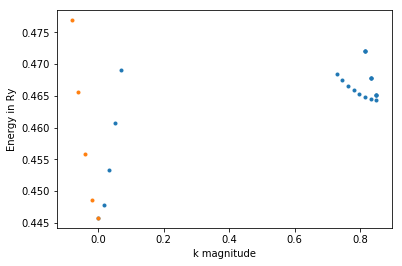

In [70]:
kpts = cart_kpts_df 
enk = enk_df 

 # def plot_bandstructure(kpts, enk): 
'''
Plots electron bandstructure. Path is hardcoded for FCC unit cell. Currently just plotting Gamma-L and Gamma-X 
Parameters: 
------------ 
kpts : dataframe containing 
    k_inds : vector_like, shape (n,1) 
    Index of k point 

    'kx [1/A]' : vector_like, shape (n,1) 
    x-coordinate in Cartesian momentum space     

    'ky [1/A]' : vector_like, shape (n,1) 
    y-coordinate in Cartesian momentum space 

    'kz [1/A]' : vector_like, shape (n,1) 
    z-coordinate in Cartesian momentum space 

enk : dataframe containing 
    k_inds : vector_like, shape (n,1) 
    Index of k point 

    band_inds : vector_like, shape (n,1) 
    Band index 

    energy [Ryd] : vector_like, shape (n,1) 
    Energy associated with k point in Rydberg units 

Returns: 
--------- 
No variable returns. Just plots the dispersion  
'''
# Lattice constant and reciprocal lattice vectors 
# b1 = 2 pi/a (kx - ky + kz) 
# b2 = 2 pi/a (kx + ky - kz) 
# b3 = 2 pi/a (-kx + ky + kz) 
a = 5.556 #[A] 
b1 = (2*np.pi/a) * np.array([1, -1, 1]) 
b2 = (2*np.pi/a) * np.array([1, 1, -1]) 
b3 = (2*np.pi/a) * np.array([-1, 1, 1]) 

# L point in BZ is given by 0.5*b1 + 0.5*b2 + 0.5*b3 
# X point in BZ is given by 0.5*b2 + 0.5*b3 
lpoint = 0.5 * (b1 + b2 + b3) 
xpoint = 0.5 * (b2 + b3) 

# We can find kpoints along a path just by considering a dot product with lpoint and xpoint vectors. 
# Any kpoints with angle smaller than some tolerance are considered on the path and we can plot their corresponding frequencies 
deg2rad = 2*np.pi/360 
ang_tol = 1 * deg2rad  # 1 degree in radians 

enkonly = np.array(enk['energy [Ryd]'])[:, np.newaxis] 

kptsonly = np.array(kpts[['kx [1/A]', 'ky [1/A]', 'kz [1/A]']]) / (2*np.pi/a) 
kptsmag = np.linalg.norm(kptsonly, axis=1)[:, np.newaxis] 

dot_l = np.divide(np.dot(kptsonly, lpoint[:, np.newaxis]), kptsmag) / np.linalg.norm(lpoint) 
dot_x = np.divide(np.dot(kptsonly, xpoint[:, np.newaxis]), kptsmag) / np.linalg.norm(xpoint) 
dot_l[np.isnan(dot_l)] = 0 
dot_x[np.isnan(dot_x)] = 0 

lpath = np.logical_or(np.arccos(dot_l) < ang_tol, kptsmag == 0) 
xpath = np.logical_or(np.arccos(dot_x) < ang_tol, kptsmag == 0) 

# Plot the Gamma to L bandstructure 
# trace = go.Scatter(x = kptsmag[lpath], y = enkonly[lpath], mode='markers') 
# data = [trace] 

# py.iplot(data) 
plt.figure() 
plt.plot(kptsmag[lpath], enkonly[lpath], '.') 
plt.plot(-1*kptsmag[xpath], enkonly[xpath], '.') 
plt.xlabel('k magnitude') 
plt.ylabel('Energy in Ry')